In [ ]:

import torch as th
import numpy as np
import pickle
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from pytorch_lightning import seed_everything
import torch as th
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import sys
sys.path.insert(0, '../../sample_scripts/')
import glob
import warnings
warnings.filterwarnings("ignore")

# from sample_scripts.sample_utils.inference_utils import to_tensor
from sample_scripts.sample_utils.vis_utils import plot_image
from sample_scripts.sample_utils import (
    ckpt_utils, 
    file_utils,
    params_utils,
)
from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

device = 'cuda:1'

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs, size=17):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(size, size))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def get_cfg(self):
    from config.base_config import parse_args
    cfg_file_path = glob.glob("/home/mint/guided-diffusion/config/*/*", recursive=True)
    cfg_file_path = [cfg_path for cfg_path in cfg_file_path if f"/{self.cfg_name}" in cfg_path]    # Add /{}/ to achieve a case-sensitive of folder
    print("[#] Config Path : ", cfg_file_path)
    assert len(cfg_file_path) <= 1
    assert len(cfg_file_path) > 0
    cfg_file = cfg_file_path[0]
    cfg = parse_args(ipynb={'mode':True, 'cfg':cfg_file})
    return cfg

In [ ]:
ckpt_loader = ckpt_utils.CkptLoader(log_dir="Masked_Face_woclip+BgNoHead+shadow_256", cfg_name="Masked_Face_woclip+BgNoHead+shadow_256.yaml")
cfg = ckpt_loader.cfg
# cfg.img_cond_model.in_image = cfg.img_cond_model.in_image
# cfg.img_cond_model.prep_image = [None, 'dilate=5', None]
cfg.img_model.image_size = 256
# Load dataset
dataset = 'ffhq'
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
# Load dataset
if dataset == 'itw':
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    img_dataset_path = f"/data/mint/DPM_Dataset/ITW/itw_images_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ITW/params/"
    img_ext = '.png'
    cfg.dataset.training_data = 'ITW'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/itw_images_aligned/'
elif dataset == 'ffhq':
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
    img_ext = '.jpg'
    cfg.dataset.training_data = 'ffhq_256_with_anno'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/ffhq_256/'
elif dataset in ['mp_valid', 'mp_test', 'mp_test2']:
    if dataset == 'mp_test':
        sub_f = '/MultiPIE_testset/'
    elif dataset == 'mp_test2':
        sub_f = '/MultiPIE_testset2/'
    elif dataset == 'mp_valid':
        sub_f = '/MultiPIE_validset/'
    else: raise ValueError
    img_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/{sub_f}/mp_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/{sub_f}/params/"
    img_ext = '.png'
    cfg.dataset.training_data = f'/MultiPIE/{sub_f}/'
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/mp_aligned/'
else: raise ValueError

cfg.dataset.deca_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/params/'
cfg.dataset.face_segment_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/face_segment/"
cfg.dataset.deca_rendered_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/rendered_images/"
cfg.dataset.laplacian_mask_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/eyes_segment/"
cfg.dataset.laplacian_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/laplacian/"

loader, dataset, _ = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_='valid',
    cfg=cfg,
)

from importlib import reload
sys.path.insert(0, '../../sample_scripts/cond_utils/DECA/')
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from decalib.utils.tensor_cropper import transform_points

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist()
}

deca_cfg.model.extract_tex = True
deca_cfg.rasterizer_type = 'standard'
deca_cfg.model.use_tex = True 
deca = DECA(config = deca_cfg, device='cuda', mode='shape', mask=mask)



dict_keys(['deca_masked_face_images_woclip_img', 'faceseg_nohead_img', 'faceseg_nohead_mask', 'cond_params', 'shape', 'pose', 'exp', 'cam', 'light', 'faceemb', 'tform', 'albedo', 'detail', 'shadow', 'image_name', 'raw_image', 'raw_image_path', 'image'])


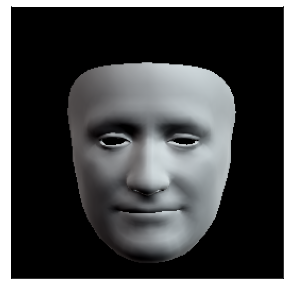

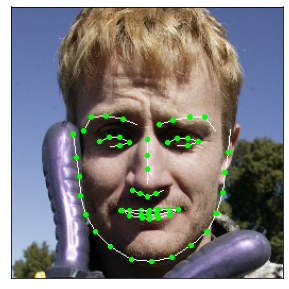

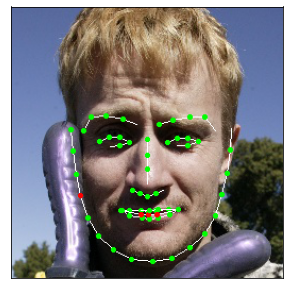

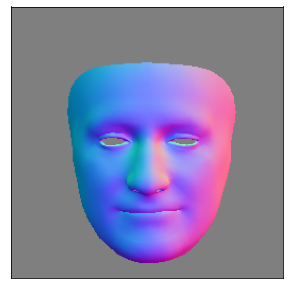

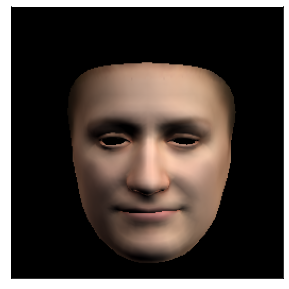

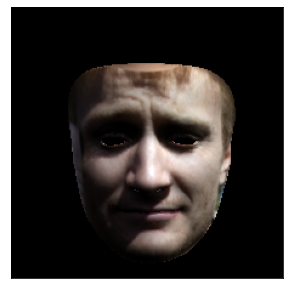

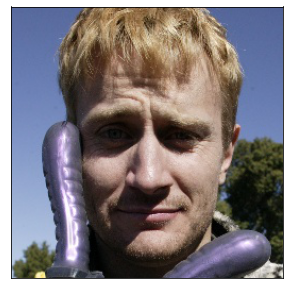

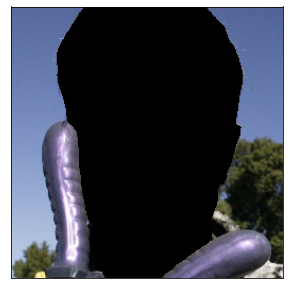

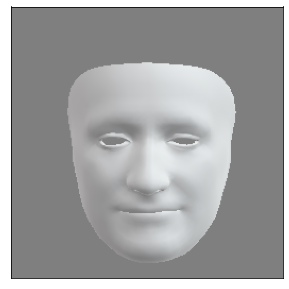

In [59]:
img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/valid/")
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg'])
# img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg', '60000.jpg', '60001.jpg', '60002.jpg', '60004.jpg'])
dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1,
                                    shuffle=False, num_workers=24)
                            
dat, model_kwargs = next(iter(subset_loader))
print(model_kwargs.keys())
rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, 
                                                        idx=0, n=len(img_idx), 
                                                        useTex=True, extractTex=True, 
                                                        deca_mode='', use_detail=True, mask=mask, repeat=False, 
                                                        deca_obj=deca)

grid = torchvision.utils.make_grid(orig_visdict['shape_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0, size=5)
grid = torchvision.utils.make_grid(orig_visdict['landmarks2d_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0, size=5)                                            
grid = torchvision.utils.make_grid(orig_visdict['landmarks3d_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0, size=5)
grid = torchvision.utils.make_grid(((orig_visdict['normal_images'] + 1) * 127.5).clamp_(0, 255).cpu())
show(grid/255.0, size=5)
grid = torchvision.utils.make_grid(orig_visdict['rendered_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0, size=5)
grid = torchvision.utils.make_grid(orig_visdict['rendered_images_uv_texture'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0, size=5)
grid = torchvision.utils.make_grid(model_kwargs['raw_image'].cpu())
show(grid/255.0, size=5)
grid = torchvision.utils.make_grid((((model_kwargs['faceseg_nohead_img'] + 1) * 127.5)).float().cpu())
show(grid/255.0, size=5)
grid = torchvision.utils.make_grid((((model_kwargs['deca_masked_face_images_woclip_img'] + 1) * 127.5)).float().cpu())
show(grid/255.0, size=5)



In [ ]:
print(orig_visdict.keys())
print(orig_visdict['trans_verts'].shape)

t_verts = orig_visdict['trans_verts_orig'].cpu().numpy()
t_verts = t_verts[0:1, v_mask['face'].tolist(), :]

import plotly.graph_objects as go
# fig = go.Figure(data=[go.Scatter3d(x=t_verts[0, :, 1], y=t_verts[0, v_mask['face'].tolist(), 1], z=t_verts[0, v_mask['face'].tolist(), 2],
fig = go.Figure(data=[go.Scatter3d(x=t_verts[0, :, 0], y=t_verts[0, :, 1], z=t_verts[0, :, 2],
                                   mode='markers', marker_size=0.7)])
fig.show()

In [ ]:
depth_image, alpha_image = deca.render.render_depth(orig_visdict['trans_verts_orig'])
# print(depth_image.shape, alpha_image.shape)
depth_image = depth_image.repeat(1,3,1,1)
alpha_image = alpha_image.repeat(1,3,1,1)
grid = torchvision.utils.make_grid((depth_image).float().cpu())
show(grid, size=5)
grid = torchvision.utils.make_grid((alpha_image).float().cpu())
show(grid, size=5)

print(depth_image.shape)
print(th.all(depth_image[0, 0, :, :] == depth_image[0, 1, :, :]))
print(th.all(depth_image[0, 0, :, :] == depth_image[0, 2, :, :]))
print(th.max(depth_image[0, 0, :, :]))
print(th.min(depth_image[0, 0, :, :]))


In [ ]:
def vis_ray(ld, depth_grid, ray, rmv_zero_depth=True):
    '''
    depth_grid : H x W x 3
    ld : B x 1 x 3
    ray : H x W x 3
    '''
    
    depth_grid_vis = depth_grid.reshape(-1, 3)
    ld_vis = ld.cpu().numpy()
    ray_vis = ray.cpu().numpy().reshape(-1, 3)
    if rmv_zero_depth:
        filter_idx = np.where(np.logical_not(np.isclose(depth_grid_vis[..., 2], 0)))[0]
        depth_grid_vis = depth_grid_vis[filter_idx, :]
        ray_vis = ray_vis[filter_idx, :]
        assert depth_grid_vis.shape[0] == ray_vis.shape[0]
    import plotly.graph_objects as go
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=depth_grid_vis[..., 0], 
                            y=depth_grid_vis[..., 1], 
                            z=depth_grid_vis[..., 2],
                            mode='markers', marker_size=0.7))
    fig.add_trace(go.Scatter3d(x=ld[0, :, 0], y=ld[0, :, 1], z=ld[0, :, 2],
                                    mode='markers', marker_size=5))
    
    draw_ray_x = list()
    draw_ray_y = list()
    draw_ray_z = list()
    for i in range(ray_vis.shape[0]):
        # Light source
        draw_ray_x.append(ld_vis[0, 0, 0])
        draw_ray_y.append(ld_vis[0, 0, 1])
        draw_ray_z.append(ld_vis[0, 0, 2])
        # Ray
        draw_ray_x.append(ld_vis[0, 0, 0] + ray_vis[i, 0])
        draw_ray_y.append(ld_vis[0, 0, 1] + ray_vis[i, 1])
        draw_ray_z.append(ld_vis[0, 0, 2] + ray_vis[i, 2])
        # No-interconnect
        draw_ray_x.append(None)
        draw_ray_y.append(None)
        draw_ray_z.append(None)
        
    ## set the mode to lines to plot only the lines and not the balls/markers
    fig.add_trace(go.Scatter3d(
        x=draw_ray_x,
        y=draw_ray_y,
        z=draw_ray_z,
        mode='lines',
        line = dict(width = 0.05, color = 'rgba(102, 0, 204, 0.1)'),
        name='Ray', 
        legendgroup=0))
    fig.show()


SH :  tensor([[[ 3.40638,  3.41821,  3.42402],
         [ 0.24472,  0.27311,  0.27874],
         [ 0.36326,  0.37438,  0.37374],
         [-0.53146, -0.51148, -0.49686],
         [-0.02802, -0.02605, -0.02550],
         [ 0.15531,  0.17207,  0.17425],
         [ 0.56558,  0.57418,  0.57290],
         [ 0.25129,  0.25584,  0.25848],
         [ 0.73258,  0.73340,  0.73769]]], dtype=torch.float64)
Light direction :  tensor([[ 0.26552,  0.37046, -0.51326]], dtype=torch.float64)
MESHGRID SHAPE :  (224, 224, 2)


torch.Size([1, 1, 3]) torch.Size([224, 224, 3])
torch.Size([224, 224, 3]) torch.Size([1, 1, 3])


100%|██████████| 224/224 [09:43<00:00,  2.60s/it]

tensor(42.78684, device='cuda:0', dtype=torch.float64)
tensor(0., device='cuda:0', dtype=torch.float64)


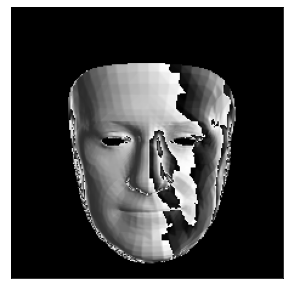

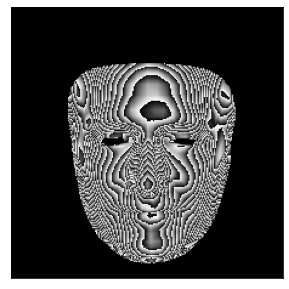

In [82]:
def sh_to_ld(sh):
    #NOTE: Roughly Convert the SH to light direction
    sh = sh.reshape(-1, 9, 3)
    print("SH : ", sh)
    ld = th.mean(sh[0:1, 1:4, :], dim=2)
    print("Light direction : ", ld)
    return ld

def gen_shadow_mask(ld, depth_grid, vis=True):
    
    #NOTE: Generate the shadow mask : Ray casting from the light source
    '''
    ld : light direction in B x 1 x 3
    depth_grid : H x W x 3
    '''
    light_distance = 1000
    num_sample_pts = 160
    
    if vis:
        ray_to_source = ld/2 - depth_grid   # Reorigin the ray to each eval_pts of depth grid
        vis_ray(ld/2, depth_grid, -ray_to_source)
    
    # Scaling the unit-light 
    ld = ld * light_distance
    print(ld.shape, depth_grid.shape)
    
    shadow_mask = th.zeros_like(depth_grid[..., [0]])
    print(depth_grid.shape, ld.shape)
    import tqdm
    for i in tqdm.tqdm(range(224)):
        for j in range(224):
            diff_list = []
            eval_pts = depth_grid[i, j, :]  # Evaluation point
            light_dir = ld[0, 0, :]
            ray_to_source = (light_dir - eval_pts)
            ray_norm = th.nn.functional.normalize(ray_to_source, p=2, dim=-1)
            ray_sample_pts = np.linspace(ray_norm, (ray_norm * 100), num=num_sample_pts+1)
            ray_sample_pts = th.tensor(ray_sample_pts)  # n_sample_pts x 3
            for idx in range(3, num_sample_pts):
                # ray_vect = ray_sample_pts[idx, :]
                ray_vect = ray_norm
                depth_vect = depth_grid[th.clip(i + ray_sample_pts[idx, 0], 0, h-1).long(), th.clip(j + ray_sample_pts[idx, 1], 0, w-1).long(), :] - eval_pts
                cross_prod = th.cross(depth_vect, ray_vect)
                distance = th.sqrt(th.sum(cross_prod**2))
                diff_list.append(distance.cpu().numpy())
            minimum_distance = th.tensor(np.min(diff_list))
            # shadow_mask[i, j] = -4*th.exp(-minimum_distance)/th.pow((1+th.exp(-minimum_distance)), 2) + 1
            shadow_mask[i, j] = minimum_distance
    return shadow_mask

ld = sh_to_ld(sh=model_kwargs['light']).cpu().numpy()[None, ...]
ld = util.batch_orth_proj(th.tensor(ld), model_kwargs['cam']); ld[:,:,1:] = -ld[:,:,1:]

depth_image, alpha_image = deca.render.render_depth(orig_visdict['trans_verts_orig'])
depth_image = depth_image.repeat(1,3,1,1)
alpha_image = alpha_image.repeat(1,3,1,1)
_, _, h, w = depth_image.shape
depth_grid = np.meshgrid(np.arange(h), np.arange(w), indexing='xy')
depth_grid = np.stack((depth_grid), axis=-1)
print("MESHGRID SHAPE : ", depth_grid.shape)
depth_grid = np.concatenate((depth_grid, depth_image[0].permute(1, 2, 0)[..., 0:1].cpu().numpy() * 100), axis=-1)

shadow_mask = gen_shadow_mask(ld, th.tensor(depth_grid.reshape(h, w, 3)), vis=True)
shadow_mask = shadow_mask.cuda() * alpha_image[0].permute(1, 2, 0).cuda()
print(th.max(shadow_mask))
print(th.min(shadow_mask))
grid = torchvision.utils.make_grid(shadow_mask.float().cpu().permute(2, 0, 1))
show(grid, size=5)

tmp = depth_grid.reshape(h, w, 3)
tmp = tmp[..., [2]]
grid = torchvision.utils.make_grid(th.tensor(tmp).permute(2, 0, 1).float().cpu())
show(grid, size=5)


[[ 3.4063814   3.4182117   3.4240203 ]
 [ 0.2447223   0.2731144   0.27873707]
 [ 0.36326286  0.37438118  0.37373984]
 [-0.53145957 -0.511477   -0.49685538]
 [-0.02802198 -0.02605348 -0.0254976 ]
 [ 0.15530688  0.17207308  0.17424926]
 [ 0.5655835   0.57417613  0.5728966 ]
 [ 0.25129333  0.25584137  0.25848323]
 [ 0.7325827   0.7334002   0.73769367]]
tensor([[[ 2.85365, -4.46444,  5.42431]]], dtype=torch.float64)


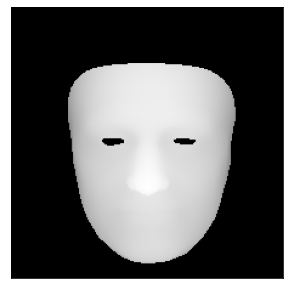

In [78]:
grid = torchvision.utils.make_grid(th.tensor(depth_grid)[..., [2]].permute(2, 0, 1).float().cpu())
show(grid, size=5)
print(model_kwargs['light'].reshape(9, 3).cpu().numpy())
print(ld)
save_dict = {
    'depth_grid':depth_grid,
    'light_direction':ld.cpu().numpy(),
    'sh':model_kwargs['light'].reshape(9, 3).cpu().numpy()
}
np.save('./depth_grid.npy', save_dict)

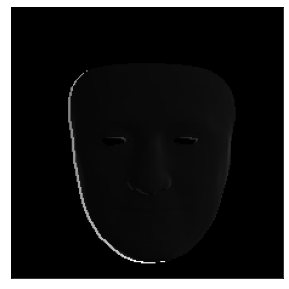

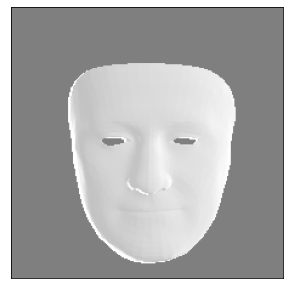

In [84]:
grid = torchvision.utils.make_grid(((shadow_mask - th.min(shadow_mask)) / (th.max(shadow_mask) - th.min(shadow_mask))).float().cpu().permute(2, 0, 1))
show(grid, size=5)

grid = torchvision.utils.make_grid(th.sigmoid(shadow_mask).float().cpu().permute(2, 0, 1))
show(grid, size=5)


In [ ]:
t_verts = orig_visdict['trans_verts_orig'].cpu().numpy()
t_verts = t_verts[0:1, v_mask['face'].tolist(), :]

# input points are in [B x N x 3]
# points_scale = [deca.cfg.dataset.image_size, deca.cfg.dataset.image_size]
# _, _, h, w = model_kwargs['raw_image'].shape
# ld = transform_points(th.tensor(ld), th.inverse(model_kwargs['tform'].reshape(-1, 3, 3)), points_scale, [h, w])

# Convert light-direction into the same convention of face verts
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=t_verts[0, :, 0], y=t_verts[0, :, 1], z=t_verts[0, :, 2],
                                   mode='markers', marker_size=0.7))
fig.add_trace(go.Scatter3d(x=ld[0, :, 0], y=ld[0, :, 1], z=ld[0, :, 2],
                                   mode='markers', marker_size=5))
fig.show()

In [ ]:
xx, yy = np.meshgrid(range(16), range(16), indexing='xy')
xx = th.nn.Parameter(th.from_numpy(np.copy(xx)).unsqueeze(0).repeat([1, 1, 1]).float(), requires_grad=False)-(16/2.0)
yy = (16/2.0)-th.nn.Parameter(th.from_numpy(np.copy(yy)).unsqueeze(0).repeat([1, 1, 1]).float(), requires_grad=False)
print(xx, xx.shape)


In [81]:
np.load('./depth_grid.npy', allow_pickle=True).items()['depth_grid']

AttributeError: 'numpy.ndarray' object has no attribute 'items'